PINC for incompressible flow in the steady-state regime.

Hyperparameters

In [1]:

hidden_size = 20
num_layers = 4
activation = 'tanh'
n_samples_PDE = 1000
n_samples_data = 100
skip_connections = False
seed = 1
num_epochs_adam = 200
num_epochs_lbfgs = 20000



In [2]:
n_samples_data_val = int(1e+3)
n_samples_PDE_val = int(1e+4)



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveletActivation(nn.Module):
    def __init__(self, hidden_size):
        super(WaveletActivation, self).__init__()
        self.w1 = nn.Parameter(torch.ones(hidden_size), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(hidden_size), requires_grad=True)        

    def forward(self, x):
        return self.w1 * torch.sin(x) + self.w2 * torch.cos(x)

class PINN(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_layers, skip_connections, activation='tanh'):
        super(PINN, self).__init__()

        self.skip_connections = skip_connections
        if skip_connections:
            self.fc_u = nn.Linear(input_size, hidden_units[0])
            self.fc_v = nn.Linear(input_size, hidden_units[0])
        
        # Inicialização das funções de ativação para U e V
        if activation == 'wavelet':
            self.activation_u = WaveletActivation(hidden_units[0]) if skip_connections else None
            self.activation_v = WaveletActivation(hidden_units[0]) if skip_connections else None
        elif activation == 'relu':
            self.activation_u = nn.ReLU() if skip_connections else None
            self.activation_v = nn.ReLU() if skip_connections else None
        elif activation == 'tanh':
            self.activation_u = nn.Tanh() if skip_connections else None
            self.activation_v = nn.Tanh() if skip_connections else None
        else:
            raise ValueError("Função de ativação inválida. Escolha entre 'relu', 'tanh' ou 'wavelet'.")

        # Main layers and activation 
        self.main_layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        
        # 1st hidden layer
        self.main_layers.append(nn.Linear(input_size, hidden_units[0]))

        # 1st layer activation function
        if activation == 'relu':
            self.activations.append(nn.ReLU())
        elif activation == 'tanh':
            self.activations.append(nn.Tanh())
        elif activation == 'wavelet':
            self.activations.append(WaveletActivation(hidden_units[0]))        
        
        # Hidden layers
        for i in range(1, len(hidden_units)):
            self.main_layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            # Adiciona ativação conforme necessário
            if activation == 'relu':
                self.activations.append(nn.ReLU())
            elif activation == 'tanh':
                self.activations.append(nn.Tanh())
            elif activation == 'wavelet':
                self.activations.append(WaveletActivation(hidden_units[i]))

        # Output Layer
        self.output_layer = nn.Linear(hidden_units[-1], output_size)

    def forward(self, x, u):
        inputs = torch.cat([x, u], dim=1)
        
        if self.skip_connections:
            U = self.activation_u(self.fc_u(inputs))
            V = self.activation_v(self.fc_v(inputs))
        
        A = inputs

        # Loop over layers
        for z_layer, activation in zip(self.main_layers, self.activations):
            Z = activation(z_layer(A))
            if self.skip_connections:
                A = (1 - Z) * U + Z * V
            else:
                A = Z

        # Output
        y = self.output_layer(A)
        return y

 



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim
import lhs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    
def pinn_loss(model, x, u):
    
    x.requires_grad_(True)
        
    # Outputs (pressure and velocity)
    outputs = model(x, u)
    P_hat = outputs[:, 0:1]  # Normalized pressure
    V_hat = outputs[:, 1:2]  # Normalized velocity
    
    # Derivatives with respect to x
    P_x = torch.autograd.grad(P_hat, x, grad_outputs=torch.ones_like(P_hat), create_graph=True)[0]
    V_x = torch.autograd.grad(V_hat, x, grad_outputs=torch.ones_like(V_hat), create_graph=True)[0]
    
    epsilon = 1e-12
    Re = rho * V_hat * Vref * D / (mu + epsilon)
    
    # Clamping
    Re = torch.clamp(Re, min=epsilon, max=1e6)
    f = 0.316 * Re**(-0.25)    
    
    eq1 = V_x
    
    eq2 = 1/rho * P_x *Pref/xref + 0.5 *f* V_hat**2/D * Vref**2
    
    loss_eq1 = torch.mean(eq1**2)
    loss_eq2 = torch.mean(eq2**2)
    
    d = {'mass_loss': loss_eq1,
         'momentum_loss': loss_eq2,
        }    
    
    return loss_eq1 + loss_eq2, d
    
    

def boundary_conditions_loss(model, x_val_0, x_val_1, u0, u1):
    
    V_pred_0 = model(x_val_0, u0)[:, 1:2]
    P_pred_0 = model(x_val_0, u0)[:, 0:1]
    
    k = 1e-5
    Pest = 2e+5
    
    v_ipr = k * (Pest - P_pred_0*Pref)
    
    loss_bc1 = torch.mean((V_pred_0*Vref - v_ipr)**2) #1m/s na entrada
    
    # BC for outlet pressure, u1 is the target value
    P_pred_1 = model(x_val_1, u1)[:, 0:1]
    loss_bc2 = torch.mean((P_pred_1 - u1)**2)  
    
    
    d = {'loss_upstream': loss_bc1,
         'loss_downstream_P': loss_bc2,
        }

    
    return loss_bc1 + loss_bc2, d


#Reference Values
rho = 1e+3
D = 0.10
mu = 0.001

Pref = 1e+5
Vref = 1.0
xref = 1e+2







Collocation and Boundary Data Generation

In [5]:
import numpy as np
from scipy.stats import qmc



def generate_collocation_points(n_samples, seed):
    
    dimensions = 2

    sampler = qmc.LatinHypercube(d=dimensions, seed=seed)
    lhs_sample = sampler.random(n=n_samples)
    
    x_points = lhs_sample[:, 0]  # Primeira coluna
    u_points = lhs_sample[:, 1]  # Segunda coluna

    x_tensor = torch.tensor(x_points, dtype=torch.float32).reshape(-1,1).to(device)
    u_tensor = torch.tensor(u_points, dtype=torch.float32).reshape(-1,1).to(device)
    
    return x_tensor, u_tensor

def generate_data_points(n_samples, seed):
    
    dimensions = 1  # variation on the control signal u

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # LHS sampling for x = 0
    sampler = qmc.LatinHypercube(d=dimensions, seed=seed)
    u_sample = sampler.random(n=n_samples)
    u_tensor_bc_0 = torch.tensor(u_sample[:, 0], dtype=torch.float32).reshape(-1,1).to(device)

    # LHS sampling for x = 1
    sampler = qmc.LatinHypercube(d=dimensions, seed=2*seed)
    u_sample = sampler.random(n=n_samples)
    u_tensor_bc_1 = torch.tensor(u_sample[:, 0], dtype=torch.float32).reshape(-1,1).to(device)

    # positions as tensors
    x_0_tensor = torch.zeros(n_samples, dtype=torch.float32).reshape(-1,1).to(device)  # x = 0 para todos os pontos
    x_1_tensor = torch.ones(n_samples, dtype=torch.float32).reshape(-1,1).to(device)  # x = 1 para todos os pontos
        
    return x_0_tensor, x_1_tensor, u_tensor_bc_0, u_tensor_bc_1
    
    
    
    
    

In [6]:
n_samples_PDE_val = n_samples_PDE

x_tensor, u_tensor = generate_collocation_points(n_samples_PDE, seed)
x_tensor_val, u_tensor_val = generate_collocation_points(n_samples_PDE_val, 25)


x_0_tensor, x_1_tensor, u_tensor_bc_0, u_tensor_bc_1 = generate_data_points(n_samples_data, seed)
x_0_tensor_val, x_1_tensor_val, u_tensor_bc_0_val, u_tensor_bc_1_val = generate_data_points(n_samples_data_val, 26)



In [7]:
x_tensor.shape, x_0_tensor.shape, x_1_tensor.shape

(torch.Size([1000, 1]), torch.Size([100, 1]), torch.Size([100, 1]))

Training

In [8]:
import torch.optim as optim
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.init as init

# initial weights for a given seed
torch.manual_seed(seed)            
model = PINN(input_size = 2, hidden_units = [hidden_size]*num_layers, output_size=2, num_layers=num_layers, skip_connections=skip_connections, activation=activation)
model = model.to(device)

best_loss = float('inf')

# Model inspection
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_params = param.numel()  # Número de parâmetros da camada
        print(f"Camada: {name} | Parâmetros: {layer_params}")
        total_params += layer_params

print(f"\nTotal de parâmetros treináveis: {total_params}")


Camada: main_layers.0.weight | Parâmetros: 40
Camada: main_layers.0.bias | Parâmetros: 20
Camada: main_layers.1.weight | Parâmetros: 400
Camada: main_layers.1.bias | Parâmetros: 20
Camada: main_layers.2.weight | Parâmetros: 400
Camada: main_layers.2.bias | Parâmetros: 20
Camada: main_layers.3.weight | Parâmetros: 400
Camada: main_layers.3.bias | Parâmetros: 20
Camada: output_layer.weight | Parâmetros: 40
Camada: output_layer.bias | Parâmetros: 2

Total de parâmetros treináveis: 1362


In [9]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-6)


loss_bc_list = []
loss_pde_list = []
total_loss_list = []

val_loss_bc_list = []
val_loss_pde_list = []
val_total_loss_list = []


# Stage 1: Training with Adam
for epoch in range(num_epochs_adam + 1):
    model.train()  # Coloca o modelo em modo de treinamento
    optimizer.zero_grad()

    # losses in the training dataset
    loss_pde, loss_components_pde = pinn_loss(model, x_tensor, u_tensor)
    loss_bc, loss_components_bc = boundary_conditions_loss(model, x_0_tensor, x_1_tensor, u_tensor_bc_0, u_tensor_bc_1)
    loss = loss_pde + loss_bc  # Perda total combinada

    # Backpropagation e weight updates
    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_loss = loss.item()


    # appending losses
    loss_bc_list.append({f"bc_{k}": v.item() for k, v in loss_components_bc.items()})
    loss_pde_list.append({f"pde_{k}": v.item() for k, v in loss_components_pde.items()})
    total_loss_list.append({"total_loss": loss.item()})
    
    model.eval()  # Coloca o modelo em modo de avaliação

    x_tensor_val = x_tensor_val.clone().detach().requires_grad_(True)

    # Validation losses
    val_loss_pde, val_loss_components_pde = pinn_loss(model, x_tensor_val, u_tensor_val)
    val_loss_bc, val_loss_components_bc = boundary_conditions_loss(model, x_0_tensor_val, x_1_tensor_val, u_tensor_bc_0_val, u_tensor_bc_1_val)
    val_loss = val_loss_pde + val_loss_bc  # Perda total de validação

    # appending validation losses
    val_loss_bc_list.append({f"bc_{k}": v.item() for k, v in val_loss_components_bc.items()})
    val_loss_pde_list.append({f"pde_{k}": v.item() for k, v in val_loss_components_pde.items()})
    val_total_loss_list.append({"total_loss": val_loss.item()})    


    # Showing progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.1e}, Learning Rate = {optimizer.param_groups[0]['lr']:.1e}")
    
    # Learning Rate scheduler
    scheduler.step(loss)



Epoch 0: Total Loss = 3.5e+00, Learning Rate = 1.0e-03
Epoch 100: Total Loss = 6.0e-02, Learning Rate = 1.0e-03
Epoch 200: Total Loss = 4.4e-02, Learning Rate = 1.0e-03


Refinement with L-BFGS

In [10]:
lbfgs_optimizer = optim.LBFGS(
    model.parameters(),
    lr=0.01,                  
    max_iter=num_epochs_lbfgs,           
    history_size=100,          
    line_search_fn="strong_wolfe",  
    tolerance_change=1e-50,    
    tolerance_grad=1e-50      
)

epoch_lbfgs = 0

def closure():

    global epoch_lbfgs  
    
    epoch_lbfgs += 1
    
    lbfgs_optimizer.zero_grad()
    
    # losses calculation
    loss_pde, loss_components_pde = pinn_loss(model, x_tensor, u_tensor)
    loss_bc, loss_components_bc = boundary_conditions_loss(model, x_0_tensor, x_1_tensor, u_tensor_bc_0, u_tensor_bc_1)
    loss = loss_pde + loss_bc
    
    # appending losses
    loss_bc_list.append({f"bc_{k}": v.item() for k, v in loss_components_bc.items()})
    loss_pde_list.append({f"pde_{k}": v.item() for k, v in loss_components_pde.items()})
    total_loss_list.append({"total_loss": loss.item()})

    # validation mode
    model.eval()

    x_tensor_val_grad = x_tensor_val.clone().detach().requires_grad_(True)

    # losses calculation in the validation dataset
    val_loss_pde, val_loss_components_pde = pinn_loss(model, x_tensor_val_grad, u_tensor_val)
    val_loss_bc, val_loss_components_bc = boundary_conditions_loss(model, x_0_tensor_val, x_1_tensor_val, u_tensor_bc_0_val, u_tensor_bc_1_val)
    val_loss = val_loss_pde + val_loss_bc  # Perda total de validação

    # appending losses
    val_loss_bc_list.append({f"bc_{k}": v.item() for k, v in val_loss_components_bc.items()})
    val_loss_pde_list.append({f"pde_{k}": v.item() for k, v in val_loss_components_pde.items()})
    val_total_loss_list.append({"total_loss": val_loss.item()})

    model.train()  # back to training mode
    
    if epoch_lbfgs % 100 == 0:
        print(f"Step {epoch_lbfgs}, Loss: {loss:.1e}")
    
    # backpropagation
    loss.backward()
    return loss

In [11]:
lbfgs_optimizer.step(closure)  # call closure for optimization


Step 100, Loss: 7.7e-04
Step 200, Loss: 5.2e-05
Step 300, Loss: 1.5e-05
Step 400, Loss: 8.2e-06
Step 500, Loss: 6.1e-06
Step 600, Loss: 3.8e-06
Step 700, Loss: 1.3e-06
Step 800, Loss: 1.2e-06
Step 900, Loss: 9.7e-07


tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)

Results Inspection

In [12]:
val_loss_bc_list[-1]

{'bc_loss_upstream': 5.043278239469373e-09,
 'bc_loss_downstream_P': 2.2280921552209065e-09}

In [13]:
val_loss_pde_list[-1]

{'pde_mass_loss': 1.7296991927651106e-07,
 'pde_momentum_loss': 7.628852927155094e-07}

In [14]:
val_total_loss_list[-1]

{'total_loss': 9.431265652892762e-07}

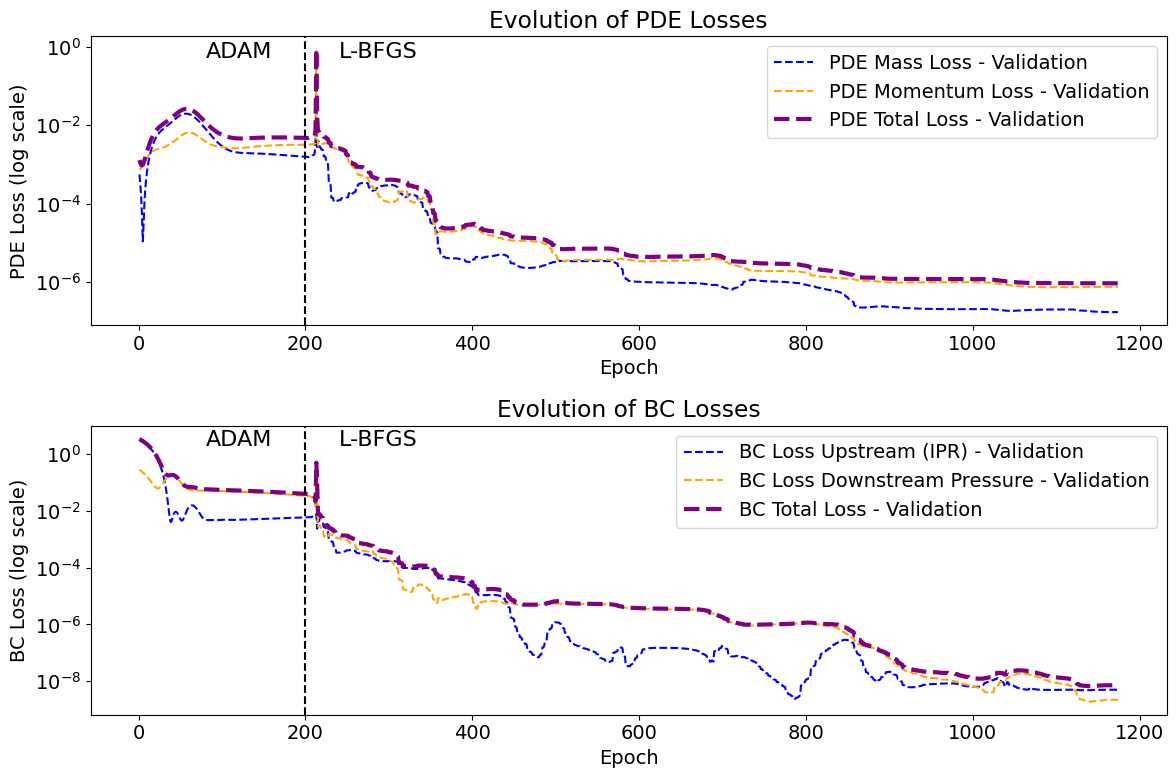

In [15]:
import matplotlib.pyplot as plt
import numpy as np


pde_mass_loss = [epoch_loss["pde_mass_loss"] for epoch_loss in loss_pde_list]
pde_momentum_loss = [epoch_loss["pde_momentum_loss"] for epoch_loss in loss_pde_list]
pde_total_loss = [sum(epoch.values()) for epoch in loss_pde_list]

val_pde_mass_loss = [epoch_loss["pde_mass_loss"] for epoch_loss in val_loss_pde_list]
val_pde_momentum_loss = [epoch_loss["pde_momentum_loss"] for epoch_loss in val_loss_pde_list]
val_pde_total_loss = [sum(epoch.values()) for epoch in val_loss_pde_list]

bc_loss_upstream = [epoch_loss["bc_loss_upstream"] for epoch_loss in loss_bc_list]
bc_loss_downstream_P = [epoch_loss["bc_loss_downstream_P"] for epoch_loss in loss_bc_list]
bc_total_loss = [sum(epoch.values()) for epoch in loss_bc_list]

val_bc_loss_upstream = [epoch_loss["bc_loss_upstream"] for epoch_loss in val_loss_bc_list]
val_bc_loss_downstream_P = [epoch_loss["bc_loss_downstream_P"] for epoch_loss in val_loss_bc_list]
val_bc_total_loss = [sum(epoch.values()) for epoch in val_loss_bc_list]

epochs = np.arange(1, len(loss_pde_list) + 1)

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(12, 8))

plt.subplot(2,1,1)

plt.plot(epochs, val_pde_mass_loss, '--', label="PDE Mass Loss - Validation", color='blue')
plt.plot(epochs, val_pde_momentum_loss, '--', label="PDE Momentum Loss - Validation", color='orange')
plt.plot(epochs, val_pde_total_loss, '--', label="PDE Total Loss - Validation", color='purple', linewidth=3)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("PDE Loss (log scale)")
plt.title("Evolution of PDE Losses")

# Vertical line indicating switching from Adam to L-BFGS
plt.axvline(x=num_epochs_adam, color='black', linestyle='--')
ymin, ymax = plt.ylim()
plt.text(num_epochs_adam - 40, ymax*0.7, "ADAM", horizontalalignment='right', verticalalignment='top', fontsize=16)
plt.text(num_epochs_adam + 40, ymax*0.7, "L-BFGS", horizontalalignment='left', verticalalignment='top', fontsize=16)

plt.legend()

# BC Loss

plt.subplot(2,1,2)
plt.plot(epochs, val_bc_loss_upstream, '--', label="BC Loss Upstream (IPR) - Validation", color='blue')
plt.plot(epochs, val_bc_loss_downstream_P, '--', label="BC Loss Downstream Pressure - Validation", color='orange')
plt.plot(epochs, val_bc_total_loss, '--', label="BC Total Loss - Validation", color='purple', linewidth=3)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("BC Loss (log scale)")
plt.title("Evolution of BC Losses")

# Vertical line indicating switching from Adam to L-BFGS
plt.axvline(x=num_epochs_adam, color='black', linestyle='--')
ymin, ymax = plt.ylim()
plt.text(num_epochs_adam -40, ymax*0.7, "ADAM", horizontalalignment='right', verticalalignment='top', fontsize=16)
plt.text(num_epochs_adam +40, ymax*0.7, "L-BFGS", horizontalalignment='left', verticalalignment='top', fontsize=16)

plt.legend()
plt.tight_layout()
#plt.savefig('PINC_Steady_State_Training.pdf')
plt.show()


The training process of the PINC in the steady-state framework highlights the importance of normalizing the governing mass and momentum equations, ensuring a balanced contribution from both terms. This normalization allows the network to converge to a sufficiently small validation loss over the epochs. Additionally, a similar equilibrium is observed in the boundary condition losses, further attributed to the applied normalization.The training begins with 200 epochs using the ADAM optimizer, followed by further refinement with the L-BFGS optimizer, which requires additional iterations to achieve improved performance.

Making predictions with the PINC model

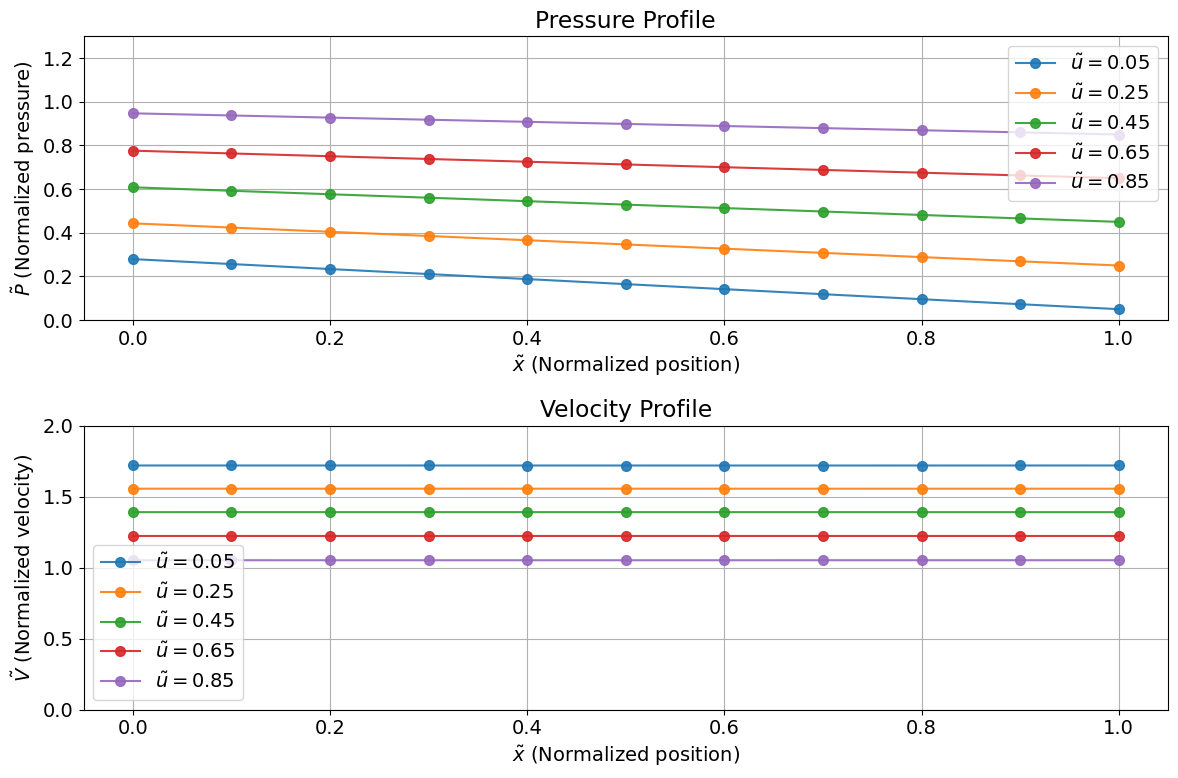

In [16]:
import matplotlib.pyplot as plt
import torch

plt.rcParams.update({'font.size': 14})


model.eval()

# Normalized x ranging from 0 to 1
x_values = torch.linspace(0, 1, 101).reshape(-1, 1).to(device)

# Normalized control signals
u_values = torch.arange(0.05, 1.05, 0.20).reshape(-1, 1).to(device)


plt.figure(figsize=(12, 8))

for u in u_values:
    u_sample = torch.ones_like(x_values).to(device) * u
    
    # PINC prediction
    with torch.no_grad():
        predictions = model(x_values, u_sample)
        pressure_values = predictions[:, 0].cpu().numpy().squeeze()  # Primeira saída: pressão
        velocity_values = predictions[:, 1].cpu().numpy().squeeze()  # Segunda saída: velocidade

    # converting to numpy for plot purposes
    x_values_np = x_values.cpu().numpy().squeeze()


    # Pressure plot
    plt.subplot(2, 1, 1)
    plt.plot(x_values_np, pressure_values, '-o', label=f'$\\tilde{{u}} = {u.item():.2f}$', linewidth=1.5, markersize=7, markevery=10, alpha=0.9)

    # Velocity Plot
    plt.subplot(2, 1, 2)
    plt.plot(x_values_np, velocity_values, '-o', label=f'$\\tilde{{u}} = {u.item():.2f}$', linewidth=1.5, markersize=7, markevery=10, alpha=0.9)

# Finalizar os gráficos
# Ajuste do gráfico de pressão
plt.subplot(2, 1, 1)
plt.xlabel(r'$\tilde{x}$ (Normalized position)')
plt.ylabel(r'$\tilde{P}$ (Normalized pressure)')
plt.ylim(0, 1.3)
plt.title('Pressure Profile')
plt.grid(True)
plt.legend(fontsize=14, loc='best')

# Ajuste do gráfico de velocidade
plt.subplot(2, 1, 2)
plt.xlabel(r'$\tilde{x}$ (Normalized position)')
plt.ylabel(r'$\tilde{V}$ (Normalized velocity)')
plt.ylim(0.0, 2.0)
plt.title('Velocity Profile')
plt.grid(True)
plt.legend(fontsize=14, loc='best')

plt.tight_layout()
#plt.savefig('simulation_pinc_SS.pdf')
plt.show()


Both the velocity profiles and pressure gradients remain constant, highlighting the neural network's strong adherence to the underlying physics.